In [1]:
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

## Hamiltonian path example

<img src="Hamiltonian path example.png" alt="drawing" width="500"/>

In [2]:
# Graph
g = np.array([[0,1,1,0,1,1],
              [1,0,1,0,0,0],
              [1,1,0,1,0,1],
              [0,0,1,0,1,1],
              [1,0,0,1,0,1],
              [1,0,1,1,1,0]])
# g = np.array([[0, 1, 1, 1, 1],
#              [1, 0, 1, 1, 1],
#              [1, 1, 0, 1, 1],
#              [1, 1, 1, 0, 1],
#              [1, 1, 1, 1, 0]])


In [3]:
n_vertices = g.shape[0]
n_edges = 0
for i in range(n_vertices):
    n_edges += sum(g[i, i:])
print('number of vertices:', n_vertices)
print('number of edges:', n_edges)
print('required qubit number:', n_vertices + n_edges + 1)
iter = int(np.pi/(4*np.arcsin(1/np.sqrt(2**n_edges))) - 1/2)
# iter = np.pi/4 * np.sqrt(2**n_edges)
print('Grover iteration:', iter)

number of vertices: 6
number of edges: 10
required qubit number: 17
Grover iteration: 24


In [4]:
g_dict = {} # {edge: [vertex1, vertex2]}

edge_idx = 0
for i in range(n_vertices):
    for j in range(i, n_vertices):
        if g[i,j] == 1:
            g_dict[edge_idx] = [i, j]
            edge_idx += 1

print(g_dict)

for i in g_dict:
    print(g_dict[i][1])

{0: [0, 1], 1: [0, 2], 2: [0, 4], 3: [0, 5], 4: [1, 2], 5: [2, 3], 6: [2, 5], 7: [3, 4], 8: [3, 5], 9: [4, 5]}
1
2
4
5
2
3
5
4
5
5


In [5]:
def oracle(qc, qr_v, qr_e, qr_f, n_vertices):
    # encode
    for i in g_dict:
        qc.cry(np.pi/2, qr_e[i], g_dict[i][0])
        qc.cry(np.pi/2, qr_e[i], g_dict[i][1])
    qc.barrier()

    # set flag
    qc.mcx(v, flag)
    qc.barrier()

    # inverse
    for i in g_dict:
        qc.cry(-np.pi/2, qr_e[i], g_dict[i][0])
        qc.cry(-np.pi/2, qr_e[i], g_dict[i][1])
    qc.barrier()
    
def diffuser(qc, qr_e, ancilla):
    qc.h(qr_e)
    qc.x(qr_e)
    qc.h(qr_e[-1])
    qc.mct(qr_e[:-1], qr_e[-1])#, ancilla_qubits=ancilla)
    qc.h(qr_e[-1])
    qc.x(qr_e)
    qc.h(qr_e)

In [6]:
v = QuantumRegister(n_vertices, name='v')
e = QuantumRegister(n_edges, name='e')
flag = QuantumRegister(1, name='flag')
n_anc = 32-n_vertices-n_edges-1
anc = QuantumRegister(n_anc, name='anc')

c = ClassicalRegister(n_edges)

qc = QuantumCircuit(v, e, flag, anc, c)

qc.h(e)

qc.x(flag)
qc.h(flag)

qc.barrier()
iter = 1
for _ in range(iter):
    oracle(qc, v, e, flag, n_vertices)
    qc.barrier()
    diffuser(qc, e, anc)
    qc.barrier()


qc.measure(e, c)
qc.draw()

░ ┌─────────┐           ┌─────────┐           ┌─────────┐»
   v_0: ───────────░─┤ RY(π/2) ├───────────┤ RY(π/2) ├───────────┤ RY(π/2) ├»
                   ░ └────┬────┘┌─────────┐└────┬────┘           └────┬────┘»
   v_1: ───────────░──────┼─────┤ RY(π/2) ├─────┼─────────────────────┼─────»
                   ░      │     └────┬────┘     │     ┌─────────┐     │     »
   v_2: ───────────░──────┼──────────┼──────────┼─────┤ RY(π/2) ├─────┼─────»
                   ░      │          │          │     └────┬────┘     │     »
   v_3: ───────────░──────┼──────────┼──────────┼──────────┼──────────┼─────»
                   ░      │          │          │          │          │     »
   v_4: ───────────░──────┼──────────┼──────────┼──────────┼──────────┼─────»
                   ░      │          │          │          │          │     »
   v_5: ───────────░──────┼──────────┼──────────┼──────────┼──────────┼─────»
        ┌───┐      ░      │          │          │          │          │     »
   e_0: ┤ H ├──────░──────■──────────■──────────┼──────────┼──────────┼─────»
        ├───┤      ░                            │          │          │     »
   e_1: ┤ H ├──────░────────────────────────────■──────────■──────────┼─────»
        ├───┤      ░                                                  │     »
   e_2: ┤ H ├──────░──────────────────────────────────────────────────■─────»
        ├───┤      ░                                                        »
   e_3: ┤ H ├──────░────────────────────────────────────────────────────────»
        ├───┤      ░                                                        »
   e_4: ┤ H ├──────░────────────────────────────────────────────────────────»
        ├───┤      ░                                                        »
   e_5: ┤ H ├──────░────────────────────────────────────────────────────────»
        ├───┤      ░                                                        »
   e_6: ┤ H ├──────░────────────────────────────────────────────────────────»
        ├───┤      ░                                                        »
   e_7: ┤ H ├──────░────────────────────────────────────────────────────────»
        ├───┤      ░                                                        »
   e_8: ┤ H ├──────░────────────────────────────────────────────────────────»
        ├───┤      ░                                                        »
   e_9: ┤ H ├──────░────────────────────────────────────────────────────────»
        ├───┤┌───┐ ░                                                        »
flag_0: ┤ X ├┤ H ├─░────────────────────────────────────────────────────────»
        └───┘└───┘ ░                                                        »
 anc_0: ───────────░────────────────────────────────────────────────────────»
                   ░                                                        »
 anc_1: ───────────░────────────────────────────────────────────────────────»
                   ░                                                        »
 anc_2: ───────────░────────────────────────────────────────────────────────»
                   ░                                                        »
 anc_3: ───────────░────────────────────────────────────────────────────────»
                   ░                                                        »
 anc_4: ───────────░────────────────────────────────────────────────────────»
                   ░                                                        »
 anc_5: ───────────░────────────────────────────────────────────────────────»
                   ░                                                        »
 anc_6: ───────────░────────────────────────────────────────────────────────»
                   ░                                                        »
 anc_7: ───────────░────────────────────────────────────────────────────────»
                   ░                                                        »
 anc_8: ───────────░─────────────────────

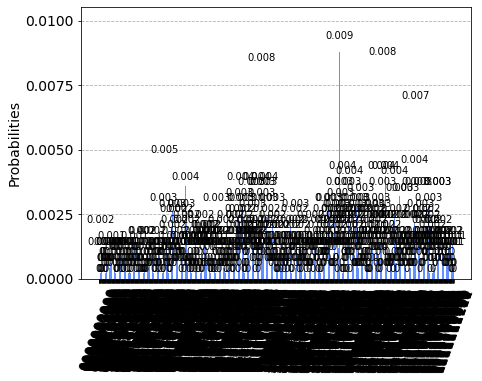

In [7]:
shots = 5012
backend = Aer.get_backend('qasm_simulator')
count = execute(qc, backend=backend, shots=shots).result().get_counts()
plot_histogram(count)

In [28]:
from collections import defaultdict

class Graph:    

    # Constructor
    def __init__(self):

        # default dictionary to store graph
        self.graph = defaultdict(list)

    # function to add an edge to graph
    def addEdge(self,u,v):
        self.graph[u].append(v)
        self.graph[v].append(u)

    # Function to print a BFS of graph
    def BFS(self, s):

        # Mark all the vertices as not visited
        visited = [False] * (max(self.graph) + 1)

        # Create a queue for BFS
        queue = []
        count = 0

        # Mark the source node as
        # visited and enqueue it
        queue.append(s)
        visited[s] = True
        count += 1

        while queue:

            # Dequeue a vertex from
            # queue and print it
            s = queue.pop(0)

            # Get all adjacent vertices of the
            # dequeued vertex s. If a adjacent
            # has not been visited, then mark it
            # visited and enqueue it
            for i in self.graph[s]:
                if visited[i] == False:
                    queue.append(i)
                    visited[i] = True
                    count += 1
        return count

def postprocess(count, g_dict, n_vertices):
    sorted_count = {k: t for k, t in sorted(count.items(), key=lambda item: item[1], reverse=True)}
    m = max(sorted_count.values())
    filtered_count = {}
    for k in sorted_count:
        if sorted_count[k] > m/2+1:
            filtered_count[k] = sorted_count[k]
        else:
            break
    answer = []
    for k in filtered_count.keys():
        g = Graph()
        for i, v in enumerate(k[::-1]):
            if v == '1':
                g.addEdge(g_dict[i][0], g_dict[i][1])
        if g.BFS(0) == n_vertices:
            answer.append(k)
    return answer

count

{'0000000000': 1,
 '0000000001': 3,
 '0100000000': 3,
 '0100000001': 3,
 '0100000010': 1,
 '0100000011': 3,
 '0100000100': 6,
 '0100000101': 3,
 '0100000110': 4,
 '0100000111': 2,
 '0100001000': 3,
 '0100001001': 1,
 '0100001010': 2,
 '0100001011': 1,
 '0100001100': 2,
 '0100001101': 2,
 '0100001110': 2,
 '0100001111': 2,
 '0100010000': 4,
 '0100010001': 3,
 '0100010010': 2,
 '0100010011': 1,
 '0100010100': 7,
 '0100010101': 4,
 '0100010110': 7,
 '0100010111': 7,
 '0100011000': 4,
 '0100011001': 2,
 '0100011010': 3,
 '0100011011': 1,
 '0100011100': 8,
 '0100011101': 1,
 '0100011110': 6,
 '0000010010': 3,
 '0100100000': 2,
 '0100100010': 2,
 '0100100011': 2,
 '0100100100': 4,
 '0100100101': 11,
 '0100100110': 1,
 '0100100111': 6,
 '0100101000': 6,
 '0100101001': 5,
 '0100101010': 1,
 '0100101011': 2,
 '0100101100': 6,
 '0100101101': 8,
 '0100101110': 3,
 '0100101111': 2,
 '0000010011': 1,
 '0100110000': 7,
 '0100110001': 9,
 '0100110010': 4,
 '0100110011': 2,
 '0100110100': 6,
 '0100110

In [9]:
count.most_frequent()

'1010111001'

In [10]:
sorted_count = {k: t for k, t in sorted(count.items(), key=lambda item: item[1], reverse=True)}
sorted_count

{'1010111001': 44,
 '1100110101': 41,
 '0111010101': 40,
 '1110010011': 33,
 '0010111101': 23,
 '1110010010': 21,
 '1011000011': 20,
 '1100110001': 20,
 '1100111101': 20,
 '1011010101': 19,
 '1101010101': 19,
 '0110011001': 18,
 '0111000101': 18,
 '0111011100': 18,
 '0011111001': 18,
 '0110111001': 17,
 '0111010100': 17,
 '0111011001': 17,
 '1010111000': 17,
 '1011010001': 17,
 '1100110110': 17,
 '1110010101': 17,
 '1110011011': 17,
 '1111010001': 17,
 '1111010011': 17,
 '1011110101': 16,
 '1101100101': 16,
 '1101110101': 16,
 '0110010111': 15,
 '0111010011': 15,
 '1010111100': 15,
 '0101010101': 14,
 '0110011010': 14,
 '0110011110': 14,
 '0111011101': 14,
 '0111110101': 14,
 '1010011001': 14,
 '1010011011': 14,
 '1011100101': 14,
 '1011101001': 14,
 '1100100011': 14,
 '1110111001': 14,
 '0010111100': 14,
 '0110111100': 13,
 '1000111100': 13,
 '1010110001': 13,
 '1010110101': 13,
 '1011100001': 13,
 '1100010011': 13,
 '1100100111': 13,
 '1110100011': 13,
 '0011010101': 13,
 '0011101101

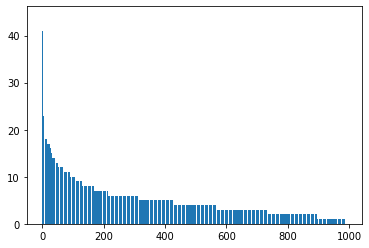

In [11]:
plt.bar(np.arange(len(sorted_count)), sorted_count.values(), align='center')

plt.show()

In [17]:
m = max(sorted_count.values())
filtered_count = {}
for k in sorted_count:
    if sorted_count[k] > m/2+1:
        filtered_count[k] = sorted_count[k]
    else:
        break
filtered_count

{'1010111001': 44, '1100110101': 41, '0111010101': 40, '1110010011': 33}

In [29]:
postprocess(count, g_dict, n_vertices)

['1010111001', '1100110101', '0111010101']